In [52]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, measure
import os
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import time

In [24]:
sample_images= []
sample_masks = []
test_images= []
test_masks = []
for i in range(1,16):
    sample_img = nib.load('C:\\Users\\prita\\Desktop\\AIMIA\AIMIA_Assignment_1\\Q2\\Sample\\SampleImages\\dwi_slice_'+str(i)+'.nii.gz')
    sample_mask = nib.load('C:\\Users\\prita\\Desktop\\AIMIA\AIMIA_Assignment_1\\Q2\\Sample\\SampleMasks\\dwi_mask_'+str(i)+'.nii.gz')
    test_img = nib.load('C:\\Users\\prita\\Desktop\\AIMIA\AIMIA_Assignment_1\\Q2\\Test\\TestImages\\dwi_slice_'+str(i)+'.nii.gz')
    test_mask = nib.load('C:\\Users\\prita\\Desktop\\AIMIA\AIMIA_Assignment_1\\Q2\\Test\\TestMasks\\dwi_mask_'+str(i)+'.nii.gz')
    sample_images.append(sample_img.get_fdata()[0,:,:])
    sample_masks.append(sample_mask.get_fdata()[0,:,:])
    test_images.append(test_img.get_fdata()[0,:,:])
    test_masks.append(test_mask.get_fdata()[0,:,:])


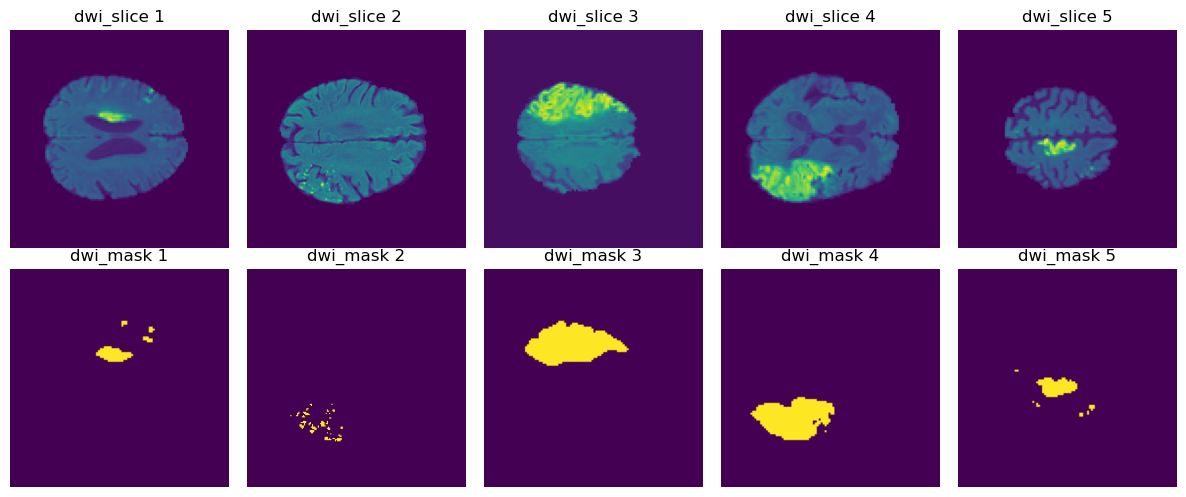

In [ ]:
plt.figure(figsize=(12,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(sample_images[i])
    plt.title('dwi_slice '+str(i+1))
    plt.axis('off')
for i in range(5):
    plt.subplot(2,5,i+6)
    plt.imshow(sample_masks[i])
    plt.title('dwi_mask '+str(i+1))
    plt.axis('off')
plt.tight_layout()
plt.show()

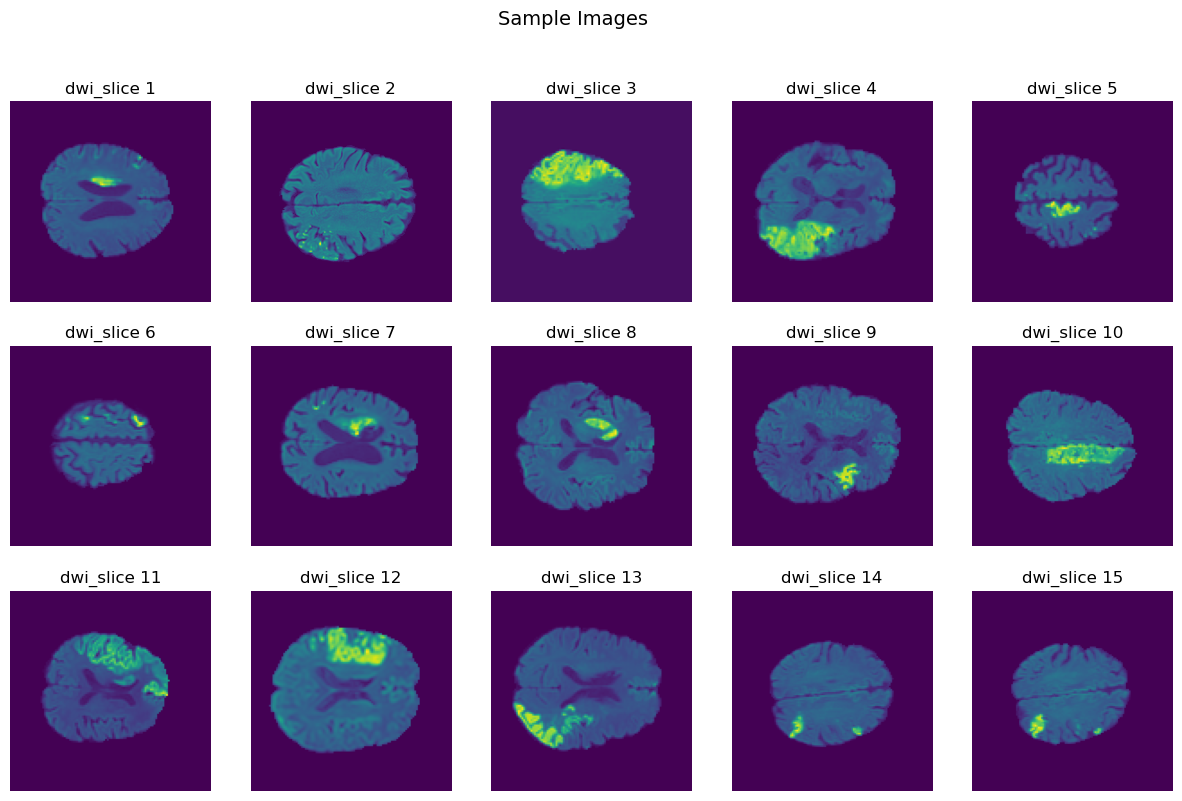

In [ ]:
plt.figure(figsize=(15,9))
for i in range(len(sample_images)):
    plt.subplot(3,5,i+1)
    plt.suptitle('Sample Images', fontsize=14)
    plt.imshow(sample_images[i])
    plt.title('dwi_slice '+str(i+1))
    plt.axis('off')
plt.show()

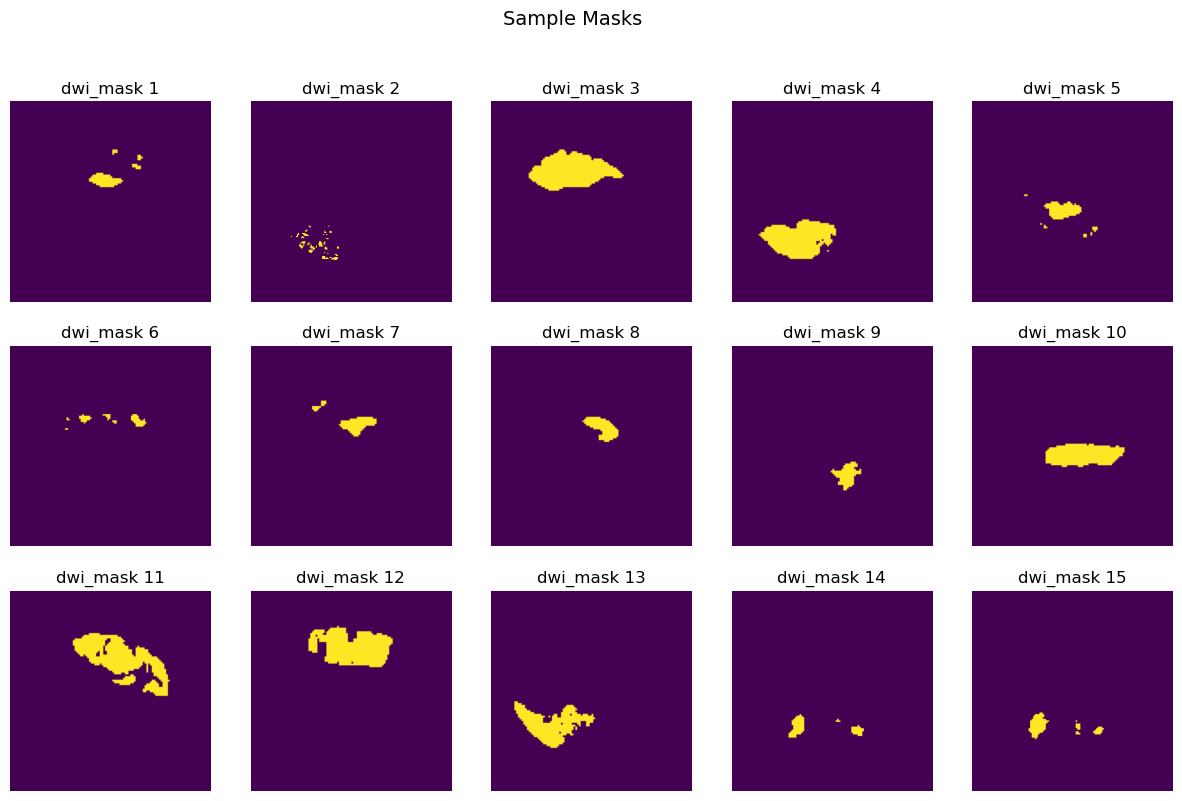

In [19]:
plt.figure(figsize=(15,9))
for i in range(len(sample_masks)):
    plt.subplot(3,5,i+1)
    plt.suptitle('Sample Masks', fontsize=14)
    plt.imshow(sample_masks[i])
    plt.title('dwi_mask '+str(i+1))
    plt.axis('off')
plt.show()

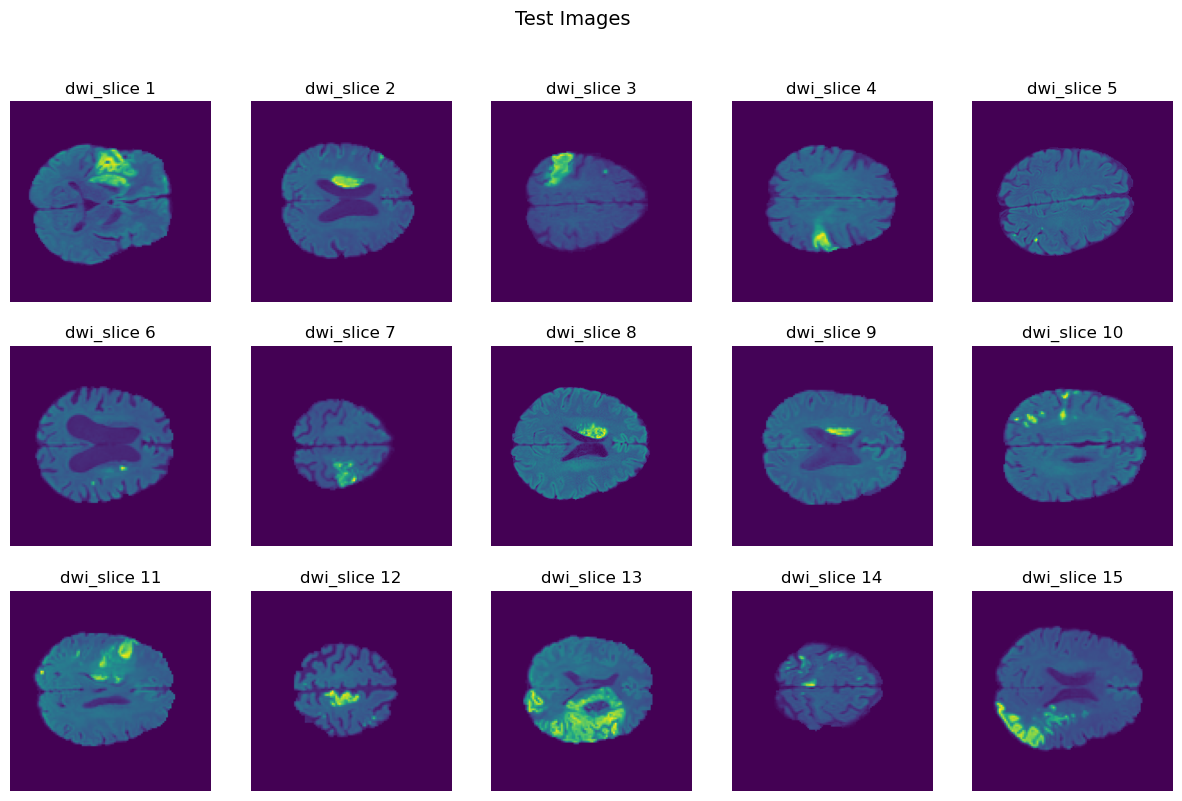

In [37]:
plt.figure(figsize=(15,9))
for i in range(len(test_images)):
    plt.subplot(3,5,i+1)
    plt.suptitle('Test Images', fontsize=14)
    plt.imshow(test_images[i])
    plt.title('dwi_slice '+str(i+1))
    plt.axis('off')
plt.show()

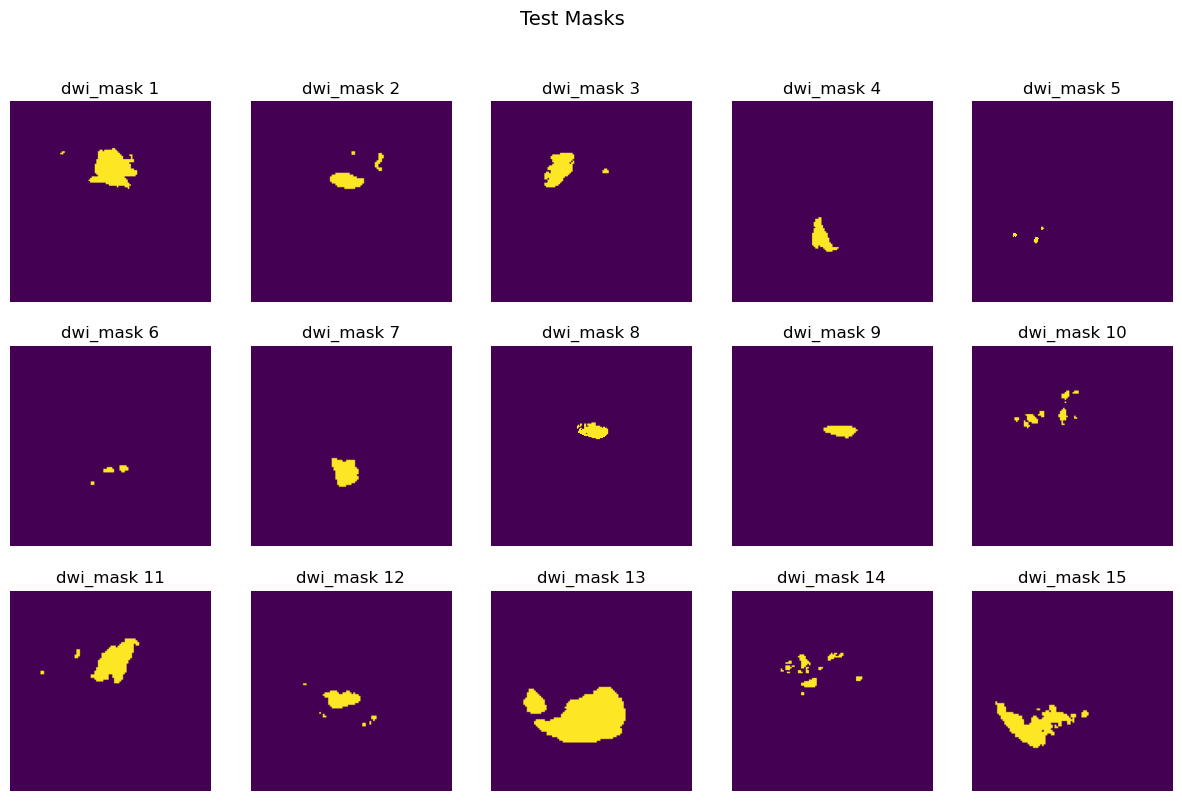

In [21]:
plt.figure(figsize=(15,9))
for i in range(len(test_masks)):
    plt.subplot(3,5,i+1)
    plt.suptitle('Test Masks', fontsize=14)
    plt.imshow(test_masks[i])
    plt.title('dwi_mask '+str(i+1))
    plt.axis('off')
plt.show()

In [40]:
sample_images[0].shape
print(f"Minimum intensity value: {np.min(sample_images[1])}, maximum intensity value: {np.max(sample_images[1])}")

Minimum intensity value: 0.0, maximum intensity value: 665.9959771092981


## Gaussian Mixture Model

In [41]:
def normalize_intensity(img, method='zscore'):
    """Normalize intensities to zero-mean unit-variance or min-max"""
    x = img.copy().astype(np.float32)
    if method == 'zscore':
        m = np.mean(x)
        s = np.std(x)
        if s == 0:
            return x - m
        return (x - m) / s
    elif method == 'minmax':
        mn = x.min()
        mx = x.max()
        if mx == mn:
            return x - mn
        return (x - mn) / (mx - mn)
    else:
        raise ValueError("Unknown method")

In [55]:
def GaussianMixtureModel(X, K, max_iter=100, tol=1e-4, reg_covar=1e-6, verbose=False):
    """
    Fit GMM to data X (n_samples, d) using EM.
    Returns: means (K,d), covariances (K,d,d), weights (K,), responsibilities (n_samples,K), log_likelihoods
    Convergence criterion: change in log-likelihood < tol (absolute)
    """
    n_samples, n_features = X.shape # Number of samples and features
    # Initialize the parameters
    np.random.seed(0) # For reproducibility
    #Normalize the data
    X = normalize_intensity(X, method='zscore')
    means = X[np.random.choice(n_samples, K, replace=False)] # Randomly choose K data points as initial means
    cov = np.cov(X, rowvar=False) # Initial covariance (shared across all components)
    if cov.ndim == 0:
        cov = np.array([[cov]])
    covariances = np.array([cov] * K) # Initial covariances for each component
    weights = np.ones(K) / K # Initial weights (uniform). This is the mixing coefficient for each Gaussian component or prior probability of each component.

    log_likelihoods = []

    for i in range(max_iter):
        # E-step: Compute responsibilities or posterior probabilities
        responsibilities = np.zeros((n_samples, K))
        for k in range(K):
            diff = X - means[k] # Difference between data points and mean
            inv_cov = np.linalg.inv(covariances[k]) # Inverse of covariance matrix
            det_cov = np.linalg.det(covariances[k]) # Determinant of covariance matrix
            #We are checking if the determinant is less than or equal to zero to avoid numerical issues. It should be positive for a valid covariance matrix.
            if det_cov <= 0:
                det_cov = 1e-6 # Avoid division by zero or negative determinant
            exponent = np.exp(-0.5 * np.sum(diff @ inv_cov * diff, axis=1)) # Exponent term of Gaussian
            coeff = 1 / np.sqrt((2 * np.pi) ** n_features * det_cov) # Coefficient term of Gaussian
            responsibilities[:, k] = weights[k] * coeff * exponent # Unnormalized responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True) # Normalize responsibilities

        # M-step: Update parameters
        Nk = responsibilities.sum(axis=0)
        for k in range(K):
            means[k] = (responsibilities[:, k][:, np.newaxis] * X).sum(axis=0) / Nk[k] # Update means
            diff = X - means[k] # Difference between data points and updated mean
            cov_k = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / Nk[k] # Update covariance
            if cov_k.ndim == 0:
                cov_k = np.array([[cov_k]])
            covariances[k] = cov_k
            weights[k] = Nk[k] / n_samples # Update weights

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(responsibilities.sum(axis=1)))
        log_likelihoods.append(log_likelihood)

        # Check for convergence
        if i > 0 and abs(log_likelihood - log_likelihoods[-2]) < tol: # If the change in log-likelihood is less than the tolerance, we consider the algorithm to have converged.
            break

    return means, covariances, weights, responsibilities, log_likelihoods

In [56]:
def select_infarct_cluster(means, weights, cluster_masks, image, min_frac=0.0005, max_frac=0.5):
    """
    Rule to pick the cluster representing infarct region:
      - infarcts on DWI are typically hyperintense => pick cluster with highest mean intensity
      - but sometimes background or artifact may also be bright; hence apply size constraints:
          keep cluster if size fraction between min_frac and max_frac.
      - If the brightest cluster is too large (>max_frac), try the next brightest, etc.
      - If none satisfy size constraints, use the brightest cluster but enforce morphological filtering.
    Inputs:
      - means: (K,d) cluster means (for d=1 intensity, means[:,0] contains intensities)
      - weights: (K,) mixing weights
      - cluster_masks: list/array of boolean masks per cluster (H,W)
      - image: original image (H,W) used for size fractions
      - min_frac, max_frac: fraction of image pixels
    Returns:
      index of chosen cluster
    """
    H, W = image.shape[:2]
    Npix = H * W
    K = len(cluster_masks)
    # For d=1, use scalar means (if d>1, use mean of intensities or intensity channel)
    # We'll assume image intensity is used: compute the mean intensity of pixels in each cluster directly as robust measure
    cluster_mean_intensity = []
    cluster_sizes = []
    for k in range(K):
        mask = cluster_masks[k]
        cluster_sizes.append(mask.sum())
        if mask.sum() == 0:
            cluster_mean_intensity.append(-np.inf)
        else:
            cluster_mean_intensity.append(np.mean(image[mask]))

    order = np.argsort(cluster_mean_intensity)[::-1]  # descending by mean intensity

    for idx in order:
        frac = cluster_sizes[idx] / max(1, Npix)
        if (frac >= min_frac) and (frac <= max_frac):
            return idx

    # if no cluster satisfied size constraints, pick the brightest but will perform morphological cleanup later
    return order[0]


In [57]:
def postprocess_mask(binary_mask, min_area=50, closing_radius=3):
    """
    Apply morphological cleanup:
     - remove small objects
     - morphological closing to fill holes
    """
    cleaned = morphology.remove_small_objects(binary_mask.astype(bool), min_size=min_area)
    # closing
    selem = morphology.disk(closing_radius)
    closed = morphology.binary_closing(cleaned, selem)
    # keep largest connected component
    labels = measure.label(closed)
    if labels.max() == 0:
        return closed.astype(np.uint8)
    props = measure.regionprops(labels)
    # find largest region
    areas = [p.area for p in props]
    largest_label = props[int(np.argmax(areas))].label
    final = labels == largest_label
    return final.astype(np.uint8)

In [58]:
def dice_coefficient(gt, pred, eps=1e-8):
    gt = gt.astype(bool)
    pred = pred.astype(bool)
    inter = np.logical_and(gt, pred).sum()
    return 2.0 * inter / (gt.sum() + pred.sum() + eps)

In [59]:
def lesion_wise_f1_and_counts(gt, pred, iou_threshold=0.1):
    """
    Lesion-wise F1:
      - find connected components in GT and pred
      - declare a GT lesion matched if any predicted lesion has IoU > threshold
      - declare a predicted lesion matched if it matches a GT
      - compute precision, recall -> F1
    Returns: f1, GT_count, pred_count
    """
    gt_labels = measure.label(gt.astype(bool))
    pred_labels = measure.label(pred.astype(bool))
    gt_props = measure.regionprops(gt_labels)
    pred_props = measure.regionprops(pred_labels)

    GT_n = len(gt_props)
    P_n = len(pred_props)
    matched_gt = 0
    matched_pred = 0

    # build bounding boxes and pixel sets for efficiency
    pred_masks = []
    for p in pred_props:
        pred_masks.append((p.label, pred_labels == p.label))

    for g in gt_props:
        gmask = (gt_labels == g.label)
        matched = False
        for plabel, pmask in pred_masks:
            inter = np.logical_and(gmask, pmask).sum()
            union = np.logical_or(gmask, pmask).sum()
            iou = inter / union if union > 0 else 0.0
            if iou >= iou_threshold:
                matched = True
                break
        if matched:
            matched_gt += 1

    # predicted matched count
    gt_masks = []
    for g in gt_props:
        gt_masks.append((g.label, gt_labels == g.label))
    for p in pred_props:
        pmask = (pred_labels == p.label)
        matched = False
        for glabel, gmask in gt_masks:
            inter = np.logical_and(gmask, pmask).sum()
            union = np.logical_or(gmask, pmask).sum()
            iou = inter / union if union > 0 else 0.0
            if iou >= iou_threshold:
                matched = True
                break
        if matched:
            matched_pred += 1

    precision = matched_pred / (P_n + 1e-8)
    recall = matched_gt / (GT_n + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8) if (precision+recall)>0 else 0.0
    return f1, GT_n, P_n

In [60]:
def segment_slice_with_gmm(slice_img, K=4, smoothing_sigma=1.0, intensity_norm='zscore',
                           min_frac=0.0005, max_frac=0.5, em_max_iter=200, em_tol=1e-5,
                           reg_covar=1e-6, verbose=False):
    """
    Input:
      slice_img: 2D numpy array (H,W) intensity
    Returns:
      final_mask (binary HxW), cluster_masks(list of HxW), means, covariances, responsibilities
    """
    H, W = slice_img.shape
    # Preprocess: smoothing
    img_s = gaussian_filter(slice_img, sigma=smoothing_sigma)
    # Normalize intensities (zscore)
    img_n = normalize_intensity(img_s, method=intensity_norm)
    # Flatten pixels as samples (n=Dpix, d=1)
    X = img_n.reshape(-1, 1)  # (n_pixels, 1)

    # Fit GMM
    means, covs, weights, resp, lls = GaussianMixtureModel(X, K, max_iter=em_max_iter, tol=em_tol, reg_covar=reg_covar, verbose=verbose)

    # build cluster masks
    labels = np.argmax(resp, axis=1)  # per-pixel cluster assignment
    cluster_masks = []
    for k in range(K):
        mask = (labels == k).reshape(H, W)
        cluster_masks.append(mask)

    # select infarct cluster using rule
    chosen_idx = select_infarct_cluster(means, weights, cluster_masks, img_n, min_frac=min_frac, max_frac=max_frac)
    chosen_mask = cluster_masks[chosen_idx].astype(np.uint8)

    # Postprocess
    final_mask = postprocess_mask(chosen_mask, min_area=50, closing_radius=3)

    return final_mask, cluster_masks, means, covs, weights, resp, lls

In [ ]:
for i in range(5):
    img = sample_images[i]
    X = img.reshape(-1, 1)  # Reshape to (n_samples, n_features)
    means, covariances, weights, responsibilities, log_likelihoods = GaussianMixtureModel(X, K=10, max_iter=100)
    segmented_img = np.argmax(responsibilities, axis=1).reshape(img.shape)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(segmented_img)
    plt.title('Segmented Image')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(sample_masks[i])
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

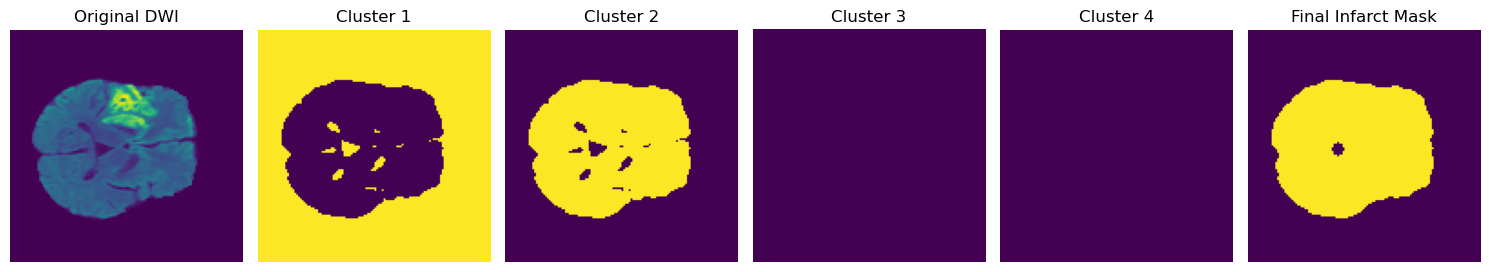

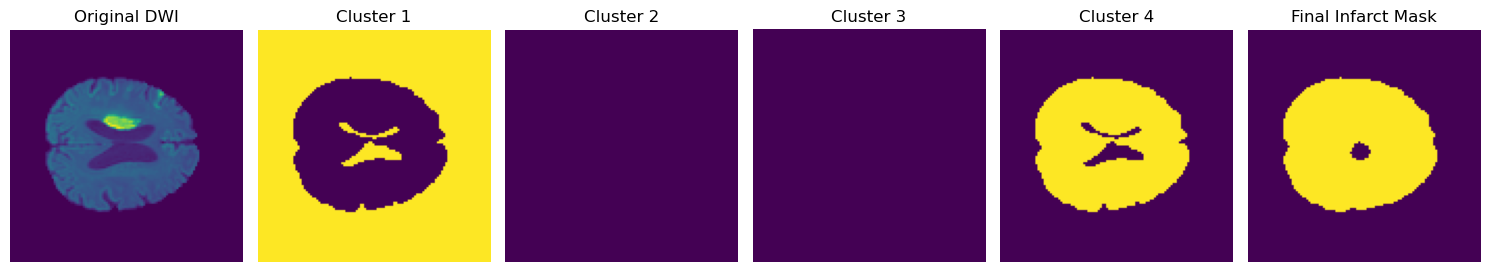

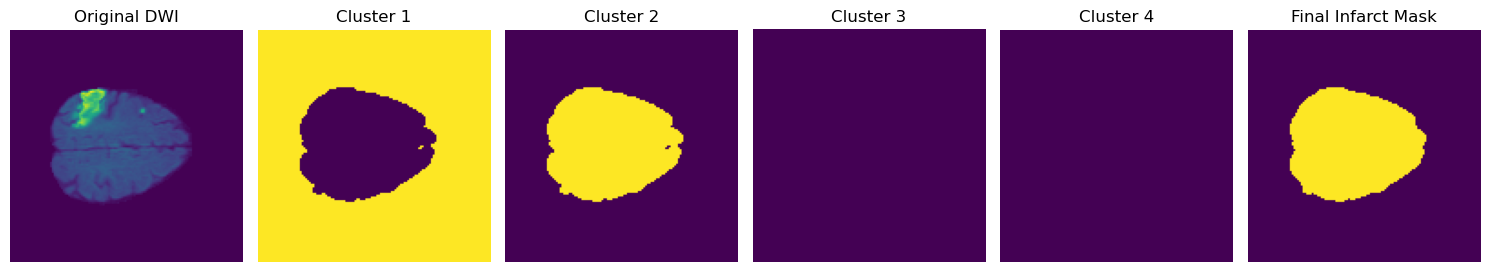

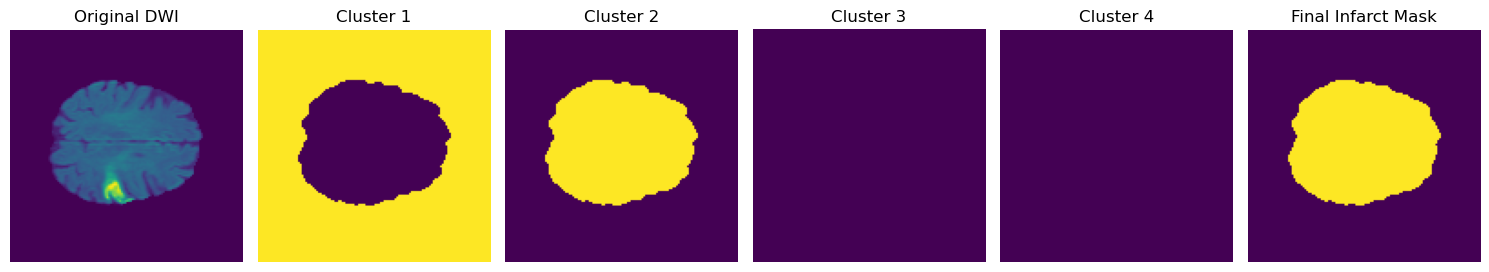

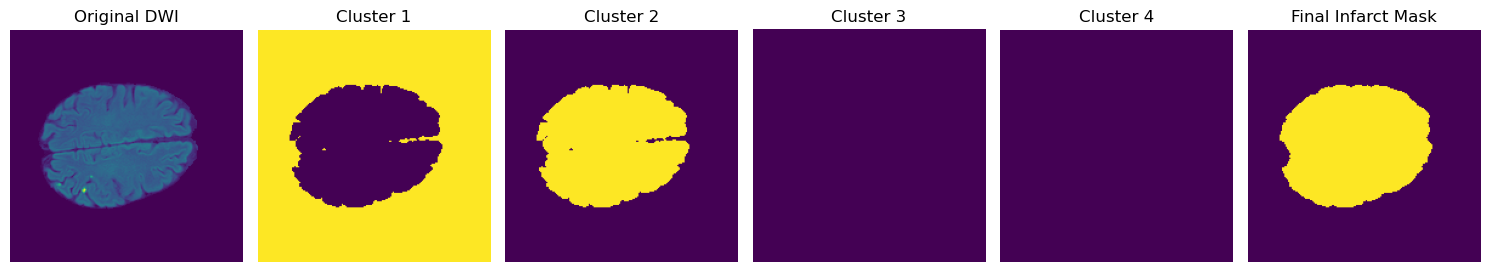

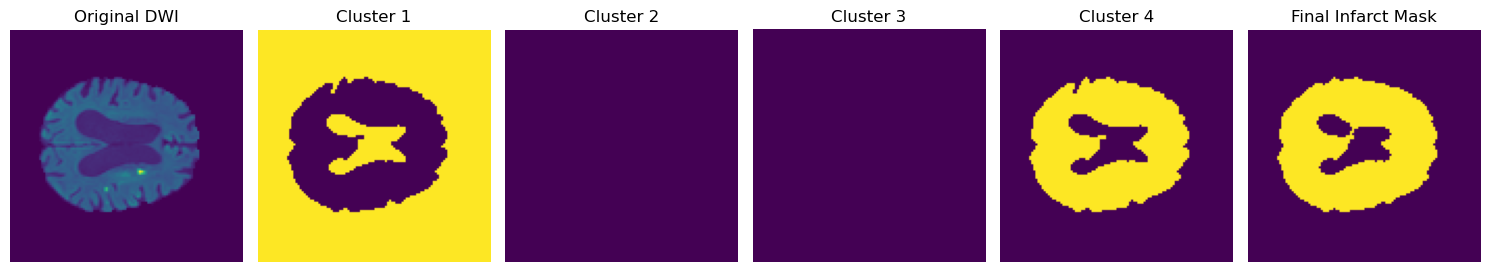

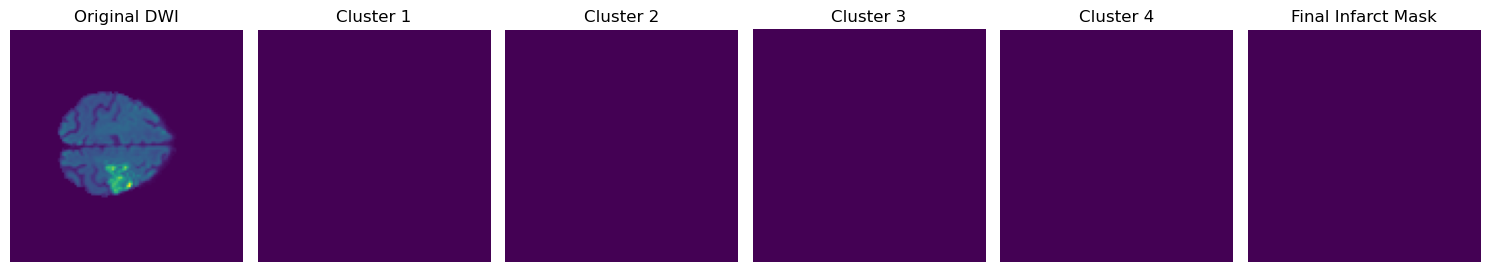

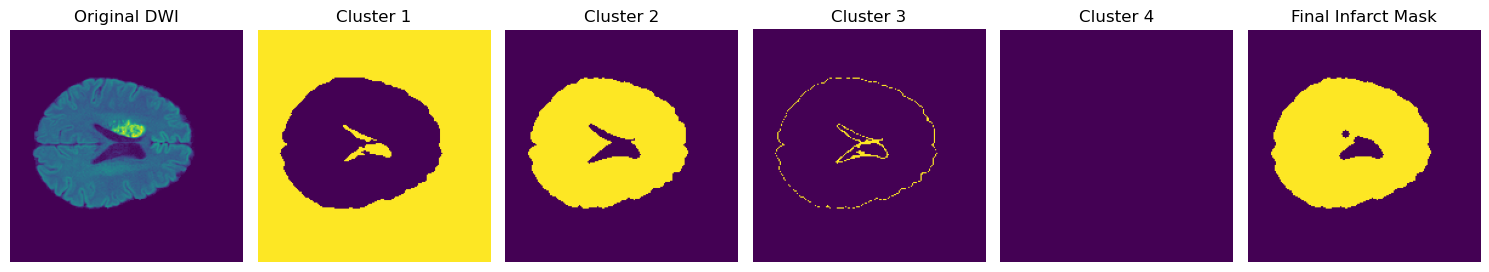

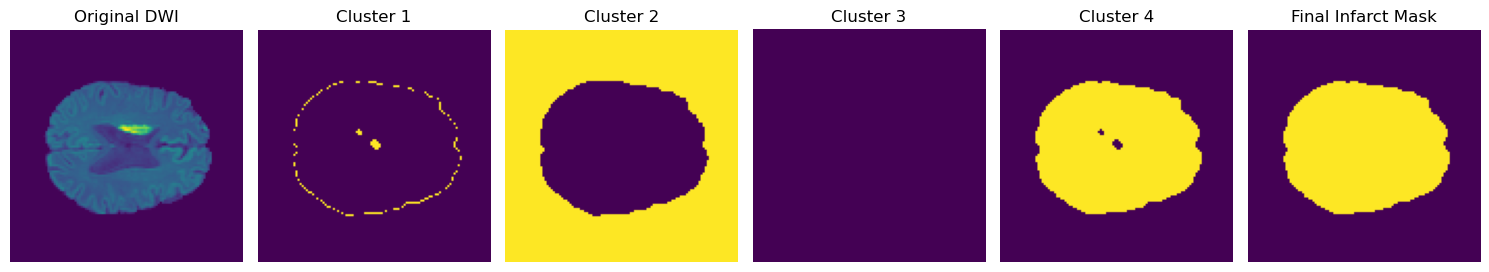

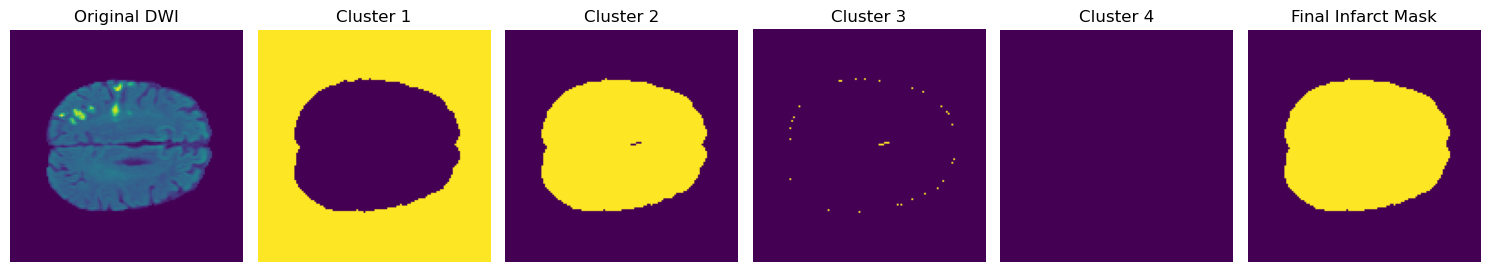

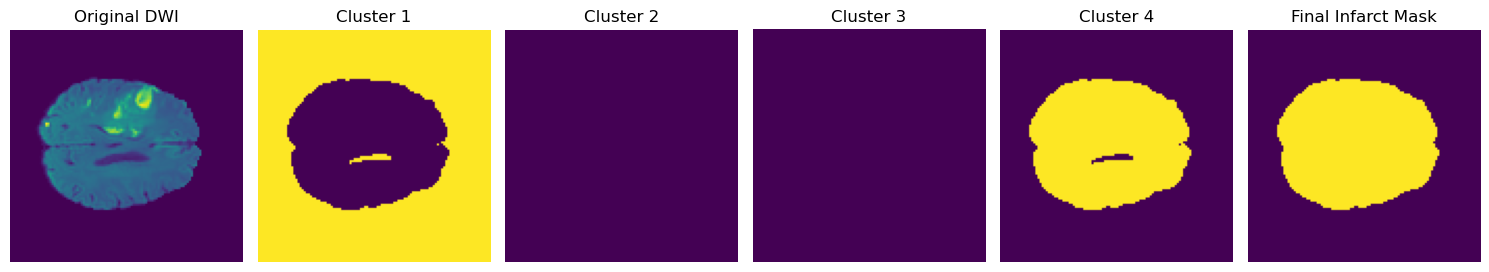

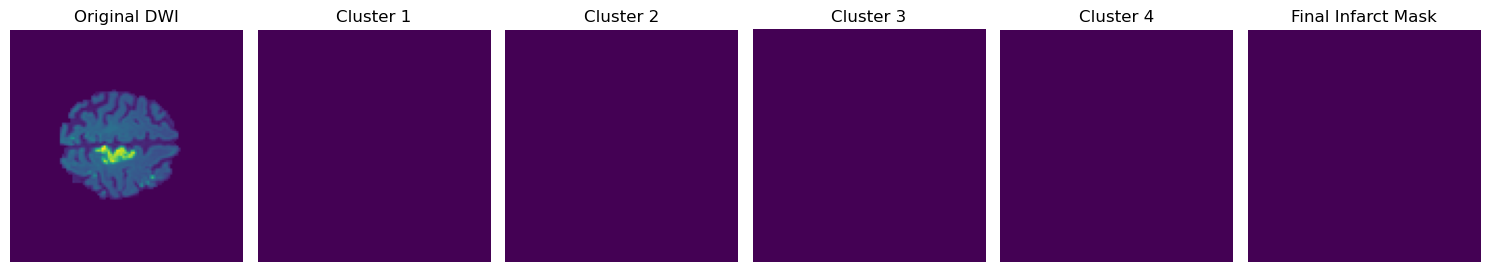

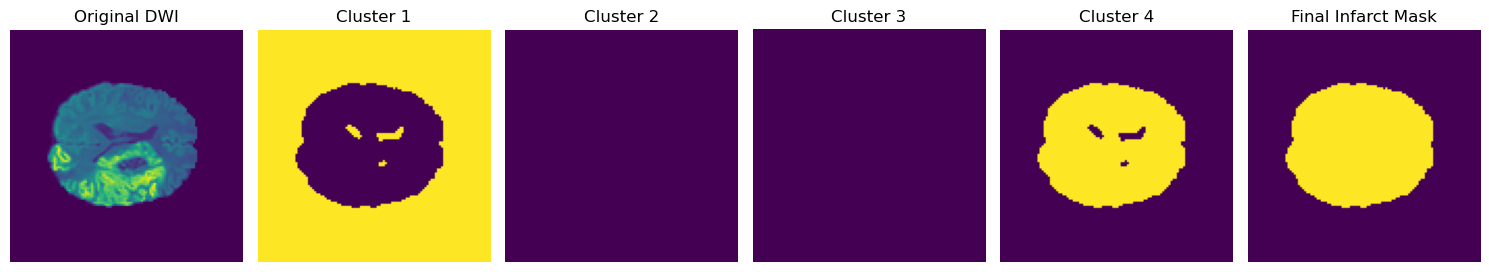

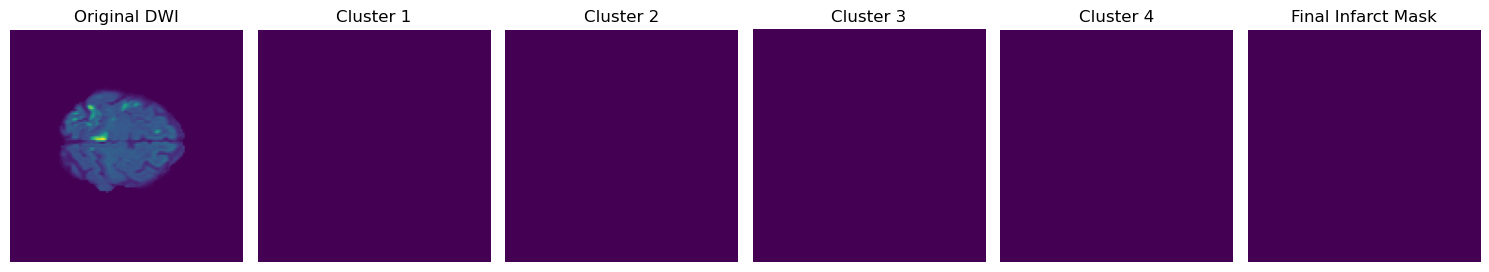

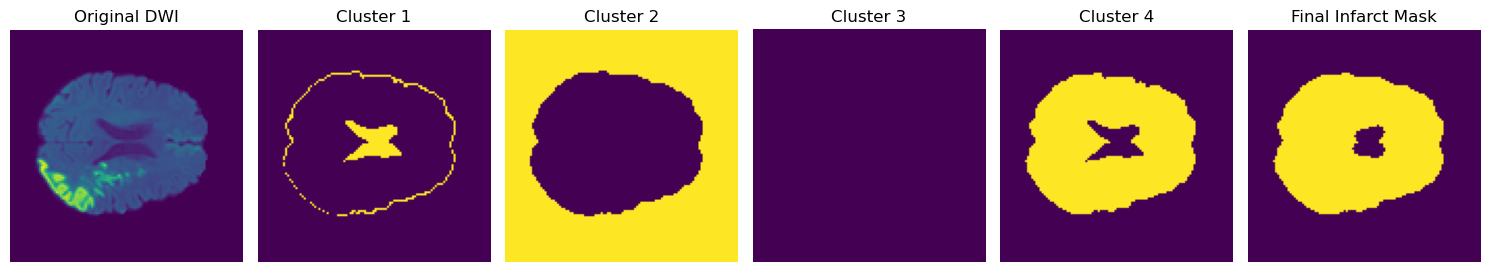

In [62]:
os.makedirs('C:\\Users\\prita\\Desktop\\AIMIA\\AIMIA_Assignment_1\\Q2\\TestResults', exist_ok=True)
K = 4
dice_scores = []
f1_scores = []
abs_element_diffs = []

for i in range(15):
    img = test_images[i]
    gt_mask = test_masks[i]
    final_mask, cluster_masks, means, covs, weights, resp, lls = segment_slice_with_gmm(img, K=4)
    
    # Save mask
    mask_nii = nib.Nifti1Image(final_mask.astype(np.uint8), affine=np.eye(4))
    nib.save(mask_nii, f'C:\\Users\\prita\\Desktop\\AIMIA\\AIMIA_Assignment_1\\Q2\\TestResults\\Test{i+1}-mask.nii.gz')
    
    # Metrics
    dice = dice_coefficient(gt_mask, final_mask)
    f1, gt_count, pred_count = lesion_wise_f1_and_counts(gt_mask, final_mask)
    abs_diff = abs(gt_count - pred_count)
    dice_scores.append(dice)
    f1_scores.append(f1)
    abs_element_diffs.append(abs_diff)
    
    # Plots
    plt.figure(figsize=(15, 5))
    plt.subplot(1, K+2, 1)
    plt.imshow(img)
    plt.title('Original DWI')
    plt.axis('off')
    for k in range(K):
        plt.subplot(1, K+2, k+2)
        plt.imshow(cluster_masks[k])
        plt.title(f'Cluster {k+1}')
        plt.axis('off')
    plt.subplot(1, K+2, K+2)
    plt.imshow(final_mask)
    plt.title('Final Infarct Mask')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Table of metrics
import pandas as pd
results_df = pd.DataFrame({
    'Slice': [f'Test{i+1}' for i in range(15)],
    'Dice': dice_scores,
    'Lesion F1': f1_scores,
    'Abs Element Diff': abs_element_diffs
})
results_df.loc['Average'] = results_df.mean(numeric_only=True)